In [1]:
# %pip install backtrader
# %pip install python-binance
# %pip install matplotlib==3.2
# %pip install pyfolio
# %pip install zipline

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import backtrader as bt
import pyfolio as pf
# import talib

In [3]:
from binance.client import Client
api_key = 'YOUR_API_KEY'
api_secret = 'YOUR_SECRET_KEY'
client = Client(api_key, api_secret)

In [4]:
SYMBOL = 'BTCUSDT'
klines = client.get_historical_klines(SYMBOL, Client.KLINE_INTERVAL_1DAY, "1 Jan, 2016", "19 Feb, 2021")

In [5]:
columns = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'ignore']
df = pd.DataFrame(klines, columns=columns)
df = df.iloc[:,:6].astype(float)
df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
# df[columns[1:5]] = np.log10(df.iloc[:,1:5])
df = df.set_index('Open time')
df.head()

,Open,High,Low,Close,Volume
Open time,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060


In [6]:
init_cash = 1000000.0

In [12]:
class FixedSize(bt.Sizer):
    params = (('stake', 10),)

    def _getsizing(self, comminfo, cash, data, isbuy):
        return self.params.stake

class Backtesting:
    def __init__(self, init_cash, strategy, df):
        self.strategy = strategy
        self.data = df
        self.result = None
        self.cerebro = bt.Cerebro()
        self.cerebro.broker.setcash(init_cash)
        self.cerebro.adddata(bt.feeds.PandasData(dataname=self.data))
        self.cerebro.addstrategy(self.strategy)
        self.cerebro.addsizer(FixedSize)
        self.cerebro.addanalyzer(bt.analyzers.PyFolio)

    def run(self):
        start_value = self.cerebro.broker.getvalue()
        self.result = self.cerebro.run()
        print('Starting Portfolio Value: %.2f' % start_value)
        print('Final Portfolio Value: %.2f' % self.cerebro.broker.getvalue())

    def plot(self):
        self.cerebro.plot()
        
    def evaluate(self):
        start_date = self.data.index[0].strftime('%Y-%m-%d')
        pyfolio = self.result[0].analyzers.getbyname('pyfolio')
        returns, positions, transactions, gross_lev = pyfolio.get_pf_items()
        pf.create_full_tear_sheet(
            returns,
            positions=positions,
            transactions=transactions,
#             gross_lev=gross_lev,
            live_start_date=start_date,
            round_trips=True)

            
def test_strategy(strategy, data):
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(init_cash)
    cerebro.adddata(bt.feeds.PandasData(dataname=data))
    cerebro.addstrategy(strategy)
    start_value = cerebro.broker.getvalue()
    cerebro.run()
    print('Starting Portfolio Value: %.2f' % start_value)
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot()

In [9]:
class SMAStrategy(bt.Strategy):
    params = dict(maperiod=20)

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
#         print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            self.bar_executed = len(self)
        # Write down: no pending order
        self.order = None

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        # Check if we are in the market
        if not self.position:
            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
        elif self.dataclose[0] < self.sma[0]:
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [10]:
class CrossoverStrategy(bt.Strategy):
    params = dict(slowmaperiod=100, fastmaperiod=20)

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
#         print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.slow_sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.slowmaperiod)
        self.fast_sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.fastmaperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            self.bar_executed = len(self)
        # Write down: no pending order
        self.order = None

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        # Check if we are in the market
        if not self.position:
            # Not yet ... we MIGHT BUY if ...
            if self.slow_sma[0] < self.fast_sma[0]:
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
        elif self.slow_sma[0] > self.fast_sma[0]:
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [16]:
test_sma_strategy = Backtesting(init_cash, SMAStrategy, df)
test_sma_strategy.run()
# test_sma_strategy.evaluate()

Starting Portfolio Value: 1000000.00
Final Portfolio Value: 1570905.60


In [15]:
test_crossover_strategy = Backtesting(init_cash, CrossoverStrategy, df)
test_crossover_strategy.run()
# test_crossover_strategy.evaluate()

Starting Portfolio Value: 1000000.00
Final Portfolio Value: 1464495.70


<IPython.core.display.Javascript object>


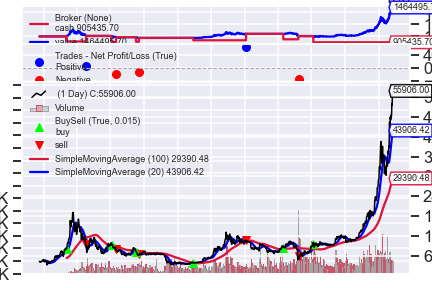

In [28]:
test_crossover_strategy.plot()